# Visual-Visuomotor Action (VVA) Project Analysis
**Student Name: Aradhya**  
**Project:** End-to-End Robot Arm Control using Visual Imitation Learning  

This notebook generates the performance metrics, graphs, and results for the VVA system subsystems:
1. **Vision Subsystem:** YOLOv8 Object Detection (Joints + Target)
2. **Control Subsystem:** Policy Network (MLP vs Attention)

In [9]:
# Universal Imports Cell - Run Once
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

# --- MATPLOTLIB BACKEND FIX ---
# Force 'Agg' backend to prevent crashes
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
from IPython.display import Image, display

plt.style.use('ggplot')

# Helper function to calculate metrics manually
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / (ss_tot + 1e-8))

# --- CONFIG ---
PROJECT_ROOT = "../"
YOLO_RESULTS_CSV = os.path.join(PROJECT_ROOT, "yolodetect/models/run/results.csv")
DATASET_NPZ = os.path.join(PROJECT_ROOT, "yolodetect/data/policy_dataset_smoothed.npz")
MODEL_MLP_PATH = os.path.join(PROJECT_ROOT, "yolodetect/models/policy_mlp_2.pth")
MODEL_ATTN_PATH = os.path.join(PROJECT_ROOT, "trained_models/policy_attention.pth")

print("Libraries loaded. Matplotlib set to Agg (Image-based display).")

Libraries loaded. Matplotlib set to Agg (Image-based display).


## 1. Vision Subsystem (YOLOv8)
Analysis of the Object Detection model trained to detect 6 Joints + 1 Target.

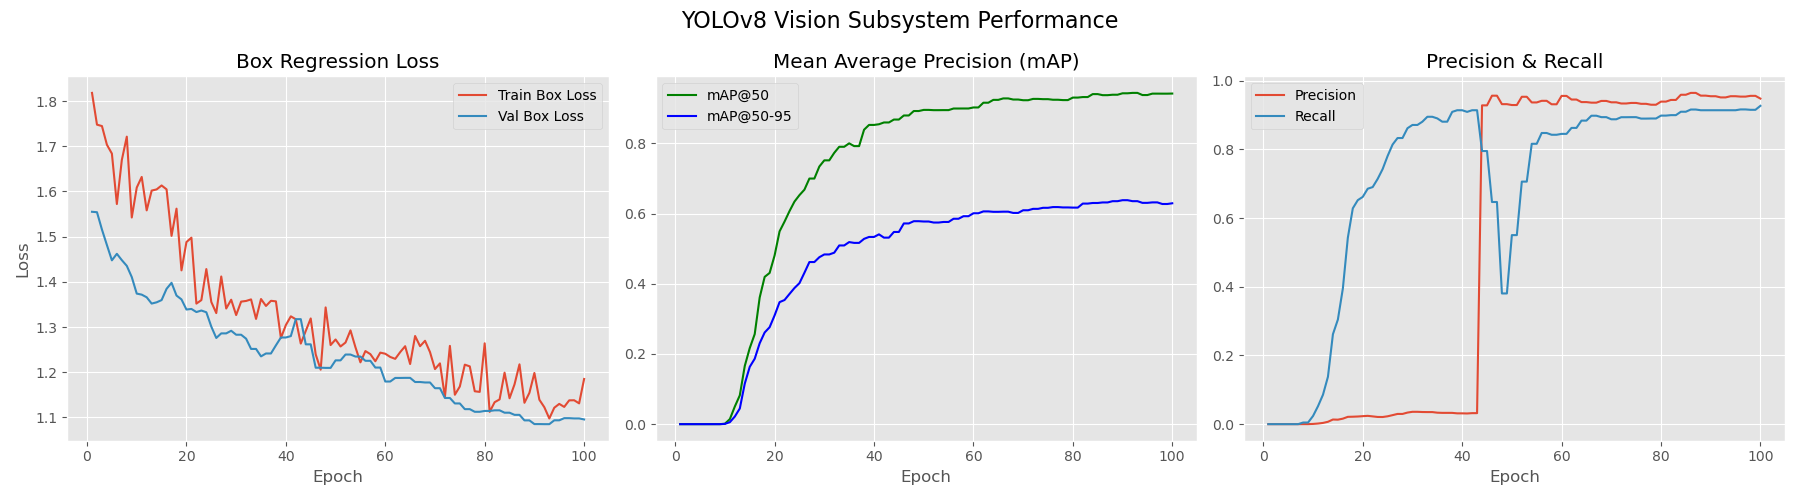

Final mAP@50: 0.9421
Final Precision: 0.9482


In [10]:
if os.path.exists(YOLO_RESULTS_CSV):
    df = pd.read_csv(YOLO_RESULTS_CSV)
    # Strip spaces from column names
    df.columns = [c.strip() for c in df.columns]
    
    # Convert to numpy arrays explicitly to avoid "Multi-dimensional indexing" errors
    epochs = df['epoch'].values
    train_box_loss = df['train/box_loss'].values
    val_box_loss = df['val/box_loss'].values
    map50 = df['metrics/mAP50(B)'].values
    map5095 = df['metrics/mAP50-95(B)'].values
    precision = df['metrics/precision(B)'].values
    recall = df['metrics/recall(B)'].values
    
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    try:
        # 1. Losses
        ax[0].plot(epochs, train_box_loss, label='Train Box Loss')
        ax[0].plot(epochs, val_box_loss, label='Val Box Loss')
        ax[0].set_title("Box Regression Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()
        
        # 2. mAP
        ax[1].plot(epochs, map50, label='mAP@50', color='green')
        ax[1].plot(epochs, map5095, label='mAP@50-95', color='blue')
        ax[1].set_title("Mean Average Precision (mAP)")
        ax[1].set_xlabel("Epoch")
        ax[1].legend()
        
        # 3. Precision / Recall
        ax[2].plot(epochs, precision, label='Precision')
        ax[2].plot(epochs, recall, label='Recall')
        ax[2].set_title("Precision & Recall")
        ax[2].set_xlabel("Epoch")
        ax[2].legend()
        
        plt.suptitle("YOLOv8 Vision Subsystem Performance", fontsize=16)
        plt.tight_layout()
        
        # SAVE AND DISPLAY
        plt.savefig('vision_metrics.png')
        plt.close()
        display(Image('vision_metrics.png'))
        
        print(f"Final mAP@50: {map50[-1]:.4f}")
        print(f"Final Precision: {precision[-1]:.4f}")
    except KeyError as e:
        print(f"Column not found in CSV: {e}")
        print("Available columns:", df.columns.tolist())
else:
    print("YOLO Results CSV not found.")

## 2. Control Subsystem (Policy Network)
Comparing the Standard MLP Policy vs the Attention-Based Policy.
Metrics: **Mean Squared Error (MSE)** and **R2 Score** on the dataset.

In [11]:
# Model Definitions
class RobotPolicyMLP(nn.Module):
    def __init__(self, input_dim=14, output_dim=6):
        super(RobotPolicyMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.net(x)

class RobotPolicyAttention(nn.Module):
    def __init__(self, output_dim=6):
        super(RobotPolicyAttention, self).__init__()
        self.embedding = nn.Linear(2, 32)
        self.attention = nn.MultiheadAttention(embed_dim=32, num_heads=4, batch_first=True)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        seq = x.view(-1, 7, 2)
        emb = self.embedding(seq)
        attn_output, _ = self.attention(emb, emb, emb)
        out = self.head(attn_output)
        return out

In [12]:
# Load Data & Evaluate
if os.path.exists(DATASET_NPZ):
    data = np.load(DATASET_NPZ)
    X_raw = data['X']
    Y_raw = data['Y'] # Ground Truth Angles
    
    X_tensor = torch.tensor(X_raw, dtype=torch.float32)
    
    device = torch.device('cpu')
    
    # --- MLP EVAL ---
    mlp_model = RobotPolicyMLP().to(device)
    Y_pred_mlp = None
    
    if os.path.exists(MODEL_MLP_PATH):
        try:
            mlp_model.load_state_dict(torch.load(MODEL_MLP_PATH, map_location=device))
            mlp_model.eval()
            with torch.no_grad():
                Y_pred_mlp = mlp_model(X_tensor).numpy()
            
            mse_mlp = calculate_mse(Y_raw, Y_pred_mlp)
            r2_mlp = calculate_r2(Y_raw, Y_pred_mlp)
            print(f"MLP Policy -> MSE: {mse_mlp:.6f}, R2 Score: {r2_mlp:.4f}")
        except Exception as e:
            print(f"Error loading MLP: {e}")
    else:
        print("MLP Model not found.")

    # --- ATTENTION EVAL ---
    attn_model = RobotPolicyAttention().to(device)
    Y_pred_attn = None
    
    if os.path.exists(MODEL_ATTN_PATH):
        try:
            attn_model.load_state_dict(torch.load(MODEL_ATTN_PATH, map_location=device))
            attn_model.eval()
            with torch.no_grad():
                Y_pred_attn = attn_model(X_tensor).numpy()
            
            mse_attn = calculate_mse(Y_raw, Y_pred_attn)
            r2_attn = calculate_r2(Y_raw, Y_pred_attn)
            print(f"Attention Policy -> MSE: {mse_attn:.6f}, R2 Score: {r2_attn:.4f}")
        except Exception as e:
             print(f"Error loading Attention Model: {e}")
    else:
        print("Attention Model not found.")
else:
    print("Dataset not found.")

MLP Policy -> MSE: 0.007685, R2 Score: 0.9243
Attention Policy -> MSE: 0.003171, R2 Score: 0.9688


### 3. Trajectory Visualization
Comparing the Predicted Joint Angles vs Ground Truth for a sample episode.

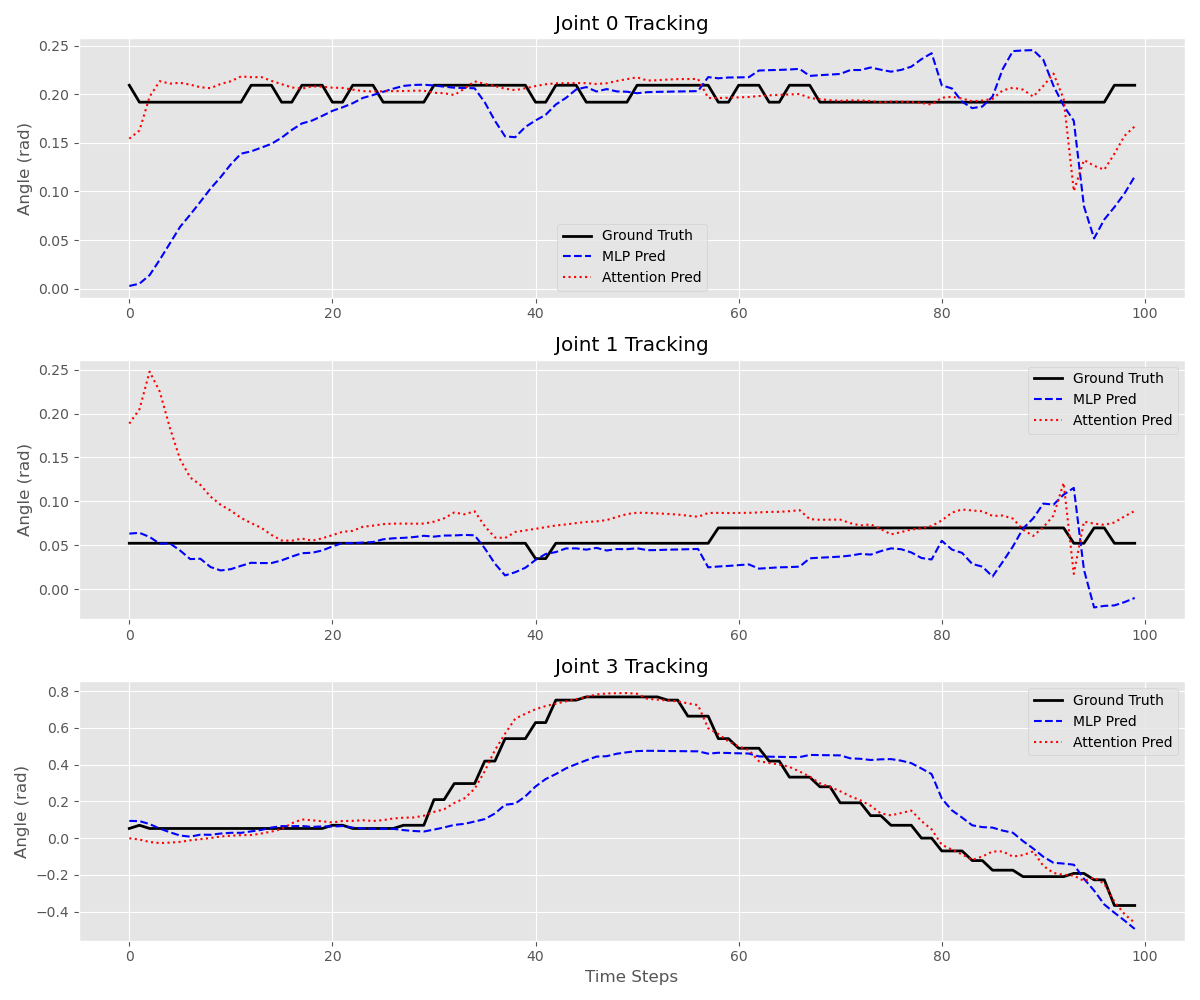

In [13]:
if Y_pred_mlp is not None:
    limit = 100
    joints_to_plot = [0, 1, 3] # Base, Shoulder, Wrist
    
    fig, ax = plt.subplots(len(joints_to_plot), 1, figsize=(12, 10))
    
    if len(joints_to_plot) == 1: ax = [ax]
    
    for i, j_idx in enumerate(joints_to_plot):
        ax[i].plot(Y_raw[:limit, j_idx], 'k-', label='Ground Truth', linewidth=2)
        ax[i].plot(Y_pred_mlp[:limit, j_idx], 'b--', label='MLP Pred')
        if Y_pred_attn is not None:
            ax[i].plot(Y_pred_attn[:limit, j_idx], 'r:', label='Attention Pred')
            
        ax[i].set_title(f"Joint {j_idx} Tracking")
        ax[i].set_ylabel("Angle (rad)")
        ax[i].legend()
        
    ax[-1].set_xlabel("Time Steps")
    plt.tight_layout()
    
    # SAVE AND DISPLAY
    plt.savefig('trajectory_comparison.png')
    plt.close()
    display(Image('trajectory_comparison.png'))

## 2. Control Subsystem Analysis
We evaluate the two trained policies (MLP vs Attention) on the validation dataset.
**Metrics:**
- **Joint-wise MSE:** Identifying which joints are hardest to control.
- **Inference Latency:** Benchmarking FPS for real-time suitability.

In [14]:
# --- MODEL ARCHITECTURES (Copied for Self-Containment) ---
class RobotPolicy(nn.Module):
    def __init__(self, input_dim=14, output_dim=6):
        super(RobotPolicy, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x): return self.net(x)

class RobotPolicyAttention(nn.Module):
    def __init__(self, output_dim=6):
        super(RobotPolicyAttention, self).__init__()
        self.embedding = nn.Linear(2, 32)
        self.attention = nn.MultiheadAttention(embed_dim=32, num_heads=4, batch_first=True)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 32, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        seq = x.view(-1, 7, 2)
        emb = self.embedding(seq)
        attn_output, _ = self.attention(emb, emb, emb)
        return self.head(attn_output)

# --- LOAD DATA & MODELS ---
if os.path.exists(DATASET_NPZ):
    print(f"Loading Data: {DATASET_NPZ}")
    data = np.load(DATASET_NPZ)
    X_val = torch.tensor(data['X'], dtype=torch.float32)
    Y_val = data['Y']
else:
    print("Dataset not found!")
    X_val, Y_val = None, None

# Load MLP
model_mlp = RobotPolicy()
if os.path.exists(MODEL_MLP_PATH):
    model_mlp.load_state_dict(torch.load(MODEL_MLP_PATH, map_location='cpu'))
    print("MLP Loaded.")
else:
    print(f"MLP not found at {MODEL_MLP_PATH}")
model_mlp.eval()

# Load Attention
model_attn = RobotPolicyAttention()
if os.path.exists(MODEL_ATTN_PATH):
    model_attn.load_state_dict(torch.load(MODEL_ATTN_PATH, map_location='cpu'))
    print("Attention Loaded.")
else:
    print(f"Attention not found at {MODEL_ATTN_PATH}")
model_attn.eval()

print("Models ready for inference.")

Loading Data: ../yolodetect/data/policy_dataset_smoothed.npz
MLP Loaded.
Attention Loaded.
Models ready for inference.


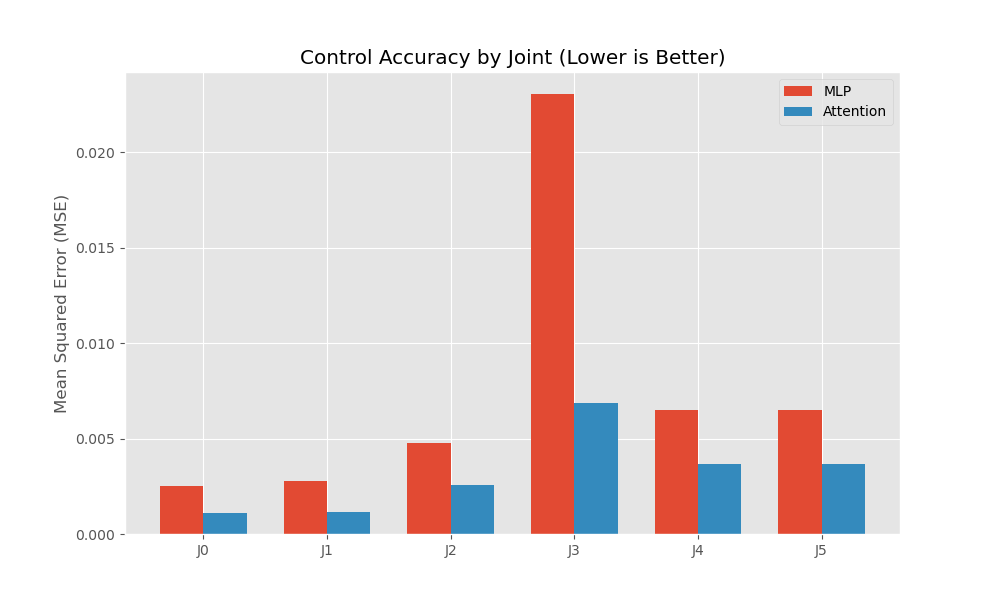

Avg MSE (MLP): 0.007685
Avg MSE (Attn): 0.003171


In [15]:
# --- JOINT-WISE MSE ANALYSIS ---
if X_val is not None:
    with torch.no_grad():
        pred_mlp = model_mlp(X_val).numpy()
        pred_attn = model_attn(X_val).numpy()

    # Calculate MSE per joint
    mse_mlp = np.mean((Y_val - pred_mlp)**2, axis=0)
    mse_attn = np.mean((Y_val - pred_attn)**2, axis=0)

    joints = ['J0', 'J1', 'J2', 'J3', 'J4', 'J5']
    x = np.arange(len(joints))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, mse_mlp, width, label='MLP')
    rects2 = ax.bar(x + width/2, mse_attn, width, label='Attention')

    ax.set_ylabel('Mean Squared Error (MSE)')
    ax.set_title('Control Accuracy by Joint (Lower is Better)')
    ax.set_xticks(x)
    ax.set_xticklabels(joints)
    ax.legend()

    # Save and view
    plt.savefig('joint_mse.png')
    plt.close()
    display(Image('joint_mse.png'))
    
    print(f"Avg MSE (MLP): {np.mean(mse_mlp):.6f}")
    print(f"Avg MSE (Attn): {np.mean(mse_attn):.6f}")

Benchmarking Single Sample Inference (Batch Size=1)...
MLP: 0.031 ms/inference | 31930.3 FPS
Attention: 0.184 ms/inference | 5428.1 FPS


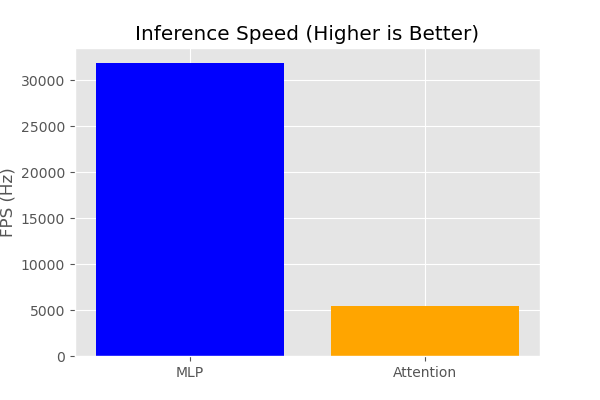

In [16]:
# --- LATENCY BENCHMARK ---
import time

def benchmark(model, x, name, loops=1000):
    # Warmup
    for _ in range(10): model(x)
    
    t0 = time.time()
    with torch.no_grad():
        for _ in range(loops):
            model(x)
    dt = time.time() - t0
    avg_time = dt / loops
    fps = 1 / avg_time
    print(f"{name}: {avg_time*1000:.3f} ms/inference | {fps:.1f} FPS")
    return fps

if X_val is not None:
    dummy_input = X_val[0:1] # Single sample inference
    print("Benchmarking Single Sample Inference (Batch Size=1)...")
    fps_mlp = benchmark(model_mlp, dummy_input, "MLP")
    fps_attn = benchmark(model_attn, dummy_input, "Attention")

    # Plot FPS
    models = ['MLP', 'Attention']
    fps_vals = [fps_mlp, fps_attn]
    
    plt.figure(figsize=(6, 4))
    plt.bar(models, fps_vals, color=['blue', 'orange'])
    plt.ylabel('FPS (Hz)')
    plt.title('Inference Speed (Higher is Better)')
    plt.savefig('latency.png')
    plt.close()
    display(Image('latency.png'))